# Modelo Personalizado: Encoder Regressor.

EL7850-1 Trabajo de Investigación Dirigido

Autor: José Rubio

Profesor: Pablo Estévez

## Librerías

In [370]:
# from IPython.display import Image

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn

import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# seaborn.set_context(context="talk")
# %matplotlib inline

## Embbeding

Objeto para llevar las secuencias procesadas a un espacio n-dimensional.

In [371]:
class Embedding(nn.Module):
  def __init__(self, d_model, inv_dim = False):
    super(Embedding, self).__init__()
    self.d_model = d_model
    self.Linear_emb = nn.Linear(1, d_model)
    self.inv_dim = inv_dim

  def forward(self, x):
    if self.inv_dim:
      x = x.T
      x = x[...,None]
      # x = torch.reshape(x, (x.size()[0], x.size()[1], 1))
    else:
      # x = torch.reshape(x, (x.size()[0], x.size()[1], 1))
      x = x[...,None]
    # print(x.type())
    x = F.relu(self.Linear_emb(x))
    return x

## Positional Encoding

Se pueden codificar de muchas maneras las posiciones, pero el trabajo propuesto en el paper utilizan la siguiente manera:

\begin{gather}
PE_{pos,2i} = sin((pos/10000^{2_{i}/d_{model}}))
\end{gather}

In [372]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    # def __init__(self, d_model, dropout, max_len=5000):
    # def __init__(self, len_src, d_model, dropout, max_len=1000):
    def __init__(self, d_model, dropout, factor_max_len=2):
        super(PositionalEncoding, self).__init__()
        # if train:
        self.d_model = d_model
        self.dropout = nn.Dropout(p=dropout)
        self.factor_max_len = factor_max_len

        # # Compute the positional encodings once in log space.
        # pe = torch.zeros(max_len, d_model)
        # position = torch.arange(0, max_len).unsqueeze(1)
        # div_term = torch.exp(torch.arange(0, d_model, 2) *
        #                      -(math.log(2*len_src) / d_model))
        # # pe = torch.zeros(max_len, d_model)
        # # position = torch.arange(0, max_len).unsqueeze(1)
        # # div_term = torch.exp(torch.arange(0, d_model, 2) *
        # #                      -(math.log(2*max_len) / d_model))
        # pe[:, 0::2] = torch.sin(position * div_term)
        # pe[:, 1::2] = torch.cos(position * div_term)
        # pe = pe.unsqueeze(0)
        # self.register_buffer('pe', pe)
        
    def forward(self, x):

        d_model = self.d_model
        factor = self.factor_max_len
        max_len = factor*x.size()[1]
        dev = x.device
        
        # Defining the initial sequence to save the positions

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model, device=dev)
        position = torch.arange(0, max_len, device=dev).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, device=x.device) *
                             -(math.log(max_len) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        # self.register_buffer('pe', pe)

        # var_x = Variable(self.pe[:, :x.size(1)], requires_grad=False)
        var_x = Variable(pe[:, :x.size(1)], requires_grad=False)
        x = x + var_x
        # x = x + Variable(self.pe[:, :x.size(1)], 
        #                  requires_grad=False)
        # print(x.size())
        return self.dropout(x)
        # if train:
        #   return self.dropout(x)
        # else:
        #   return x

## Self Attention

Capas que utilizan un sistema de atención para obtener las importancias de los elementos de una secuencia.

### Normalización de Capas Self Attention

Tras procesar los datos por una capa MultiHead Attention, entonces se aplica un normalización a los datos de salida.

In [373]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

### Self Attention

Objeto que mediante el uso de la función MultiHeadAttention de pytorch evalúa la importancia de los elementos de diversas secuencias de forma paralela

In [374]:
class SelfAttention(nn.Module):
  def __init__(self, N_layers, heads, d_model, d_ff):
    super(SelfAttention, self).__init__()
    self.Multihead = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads)
    self.NormAttention = LayerNorm(features = d_model)
    self.Linear_attention_in = nn.Linear(d_model, d_ff)
    self.Linear_attention_out = nn.Linear(d_ff, d_model)
    self.N_layers = N_layers

    # Pasada hacia adelante.

  def forward(self, x):
    for layer in range(self.N_layers):
      x_attention, x_hidden = self.Multihead(x, x, x)
      x = x + self.NormAttention(x_attention)
      # x_lin = self.Linear_attention_in(x)
      # x_lin = self.Linear_attention_out(x_lin)
      x_lin = F.relu(self.Linear_attention_in(x))
      x_lin = F.relu(self.Linear_attention_out(x_lin))
      x_lin = self.NormAttention(x_lin)
      x = x + x_lin
    return x

In [375]:
self_at = SelfAttention(N_layers=3, heads=4, d_model=100, d_ff=1024)
t_test = torch.rand(6,10,100)

In [376]:
t = torch.rand([2,3])
t

tensor([[0.0860, 0.6942, 0.4361],
        [0.3571, 0.1034, 0.1477]])

## Arquitectura del modelo completa.

Juntando los objetos definidos anteiormente, entonces se propone el siguiente sistema para realizar trabajos de regresión.

In [377]:
class EncoderRegressor(nn.Module):
  def __init__(self, len_src, Attention_layers = 4, d_model=100, n_heads=4, d_ff=1024):
    super(EncoderRegressor, self).__init__()
    self.embedding = Embedding(d_model=d_model, inv_dim=True)
    self.pos_enc = PositionalEncoding(d_model=d_model, dropout=.5)
    self.self_attention = SelfAttention(N_layers=Attention_layers, heads=n_heads, d_model=d_model, d_ff=d_ff)
    self.flatten = nn.Flatten(1,2)
    self.Linear_out = nn.Linear(len_src*d_model, 1)
    # self.Linear_out = nn.Linear(d_model, 1)

  def forward(self, x):
    x = self.embedding(x)
    x = self.pos_enc(x)
    x = self.self_attention(x)
    x = x.permute(1,0,2)
    # x = torch.reshape(x, (x.size()[1],x.size()[0], x.size()[2]))
    # x = x[-1,...]
    x = self.flatten(x)
    x = self.Linear_out(x)
    return x

## Entrenamiento del modelo

Para entrenar el sistema se diseño el siguiente objeto para el procesamiento de los datos.

In [378]:
class PrepareData(Dataset):
    def __init__(self, X, y):
        if not torch.is_tensor(X):
            self.X = X
        if not torch.is_tensor(y):
            self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

###Carga de datos

Datos Seno

In [379]:
points = 500
delta_points = 15
sin_data = []
for k in range(points):
  sin_data.append(k*delta_points)

sin_data_np = np.sin(np.radians(sin_data))

df_data = pd.DataFrame(sin_data_np, columns={'sin_data'})

Datos de series temporales reales.

In [380]:
df = pd.read_csv('AustralianWines.csv')

wine = 'Fortified' # En esta línea se escoge el vino al cual se desea realizar predicciones de ventas.
len_data = len(df)
# df_data = df[wine]

In [381]:
""" Función que entrega una extensión del array junto con sus k valores anteriores. Mientras mayor sea el k menor sera el tamaño del 
    conjunto de entrenamiento. Recibe un array de numpy y entrega una matriz de numpy con los k valores anteriores. Es necesario aplicarla para
    obtener predicciones no lineales en series temporales """

def data_lookback(array, look_back):
  array = array.reshape(len(array),)
  Serie = pd.Series(array)
  df_previous = None
  for k in range(look_back+1):
    prev_data = Serie.shift(periods=k)
    df_previous = pd.concat([prev_data, df_previous], axis=1)
    df_previous.dropna(inplace=True)
  return df_previous.to_numpy()

In [382]:
look_back = 30

scale = False
# scaler = StandardScaler()
scaler = MinMaxScaler()

if scale:
  data_1 = data_lookback(df_data.values, look_back=look_back)
  data_shifted = scaler.fit_transform(data_1)
else:
  data_shifted = data_lookback(df_data.values, look_back=look_back)

In [383]:
# X, y = load_boston(return_X_y=True)
X, y = data_shifted[:,:-1], data_shifted[:,-1]

test_size = .2

# create train and test indices
train, test = train_test_split(list(range(X.shape[0])), test_size=test_size, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True)
# train_2, test_2 = train_test_split(list(range(data_shifted.shape[0])), test_size=.2)

In [384]:
ds = PrepareData(X, y=y)

batch_size = 32

train_set = DataLoader(ds, batch_size=batch_size,
                       sampler=SubsetRandomSampler(train))
test_set = DataLoader(ds, batch_size=batch_size,
                      sampler=SubsetRandomSampler(test))

In [385]:
def count_parameters(module): 	
  return sum(p.numel() for p in module.parameters() if p.requires_grad)

In [396]:
learning_rate = 0.001
length_src = X.shape[1]
att_layers = 3
d_mod = 360
heads = 24
dff = 256

m = EncoderRegressor(len_src=length_src, Attention_layers=att_layers, d_model=d_mod, n_heads=heads, d_ff=dff)
cost_func = nn.MSELoss()
optimizer = torch.optim.Adam(m.parameters(), lr=learning_rate)

num_epochs = 2000

m.cuda()

all_losses = []
mse_losses = []
for e in range(num_epochs):
    batch_losses = []
    m.train()
    for ix, (Xb, yb) in enumerate(train_set):

        # _X = Variable(Xb).float()
        # _y = Variable(yb).float()

        _X = Xb.float().cuda()
        _y = yb.float().cuda()

        # _X = Xb.float()
        # _y = yb.float()

        #==========Forward pass===============

        preds = m(_X)
        loss = cost_func(preds, _y)

        #==========backward pass==============

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.data.item())
        all_losses.append(loss.data.item())

    mbl = np.mean(np.sqrt(batch_losses)).round(3)
    mse_losses.append(mbl)
    if e % 200 == 0:
        print("Epoch [{}/{}], Batch loss: {}".format(e, num_epochs, mbl))

# prepares model for inference when trained with a dropout layer

m.cpu()

print(m.training)
m.eval()
print(m.training)
# with torch.no_grad():
test_batch_losses = []
for _X, _y in test_set:

      # _X = Variable(_X).float()
      # _y = Variable(_y).float()

    _X = _X.float()
    _y = _y.float()

      #apply model
    test_preds = m.forward(_X)
    test_loss = cost_func(test_preds, _y)

    test_batch_losses.append(test_loss.data.item())
    print("Batch loss: {}".format(test_loss.data.item()))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [0/2000], Batch loss: 8.707
Epoch [200/2000], Batch loss: 0.777
Epoch [400/2000], Batch loss: 0.768
Epoch [600/2000], Batch loss: 0.865
Epoch [800/2000], Batch loss: 0.942
Epoch [1000/2000], Batch loss: 0.973
Epoch [1200/2000], Batch loss: 0.919
Epoch [1400/2000], Batch loss: 0.935
Epoch [1600/2000], Batch loss: 0.911
Epoch [1800/2000], Batch loss: 0.912
True
False
Batch loss: 0.5178356170654297
Batch loss: 0.578749418258667
Batch loss: 0.549329400062561


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


###Pérdida gráficas.

Visualización del MSE durante el entrenamiento

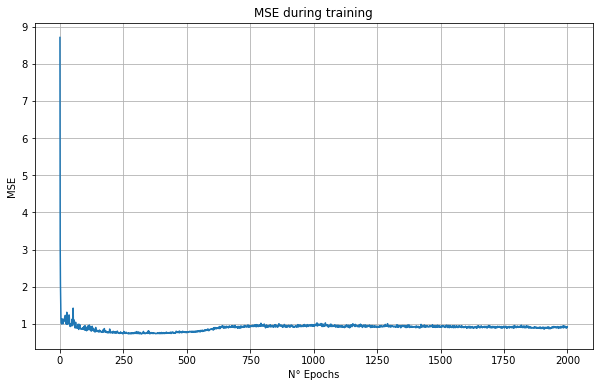

In [397]:
a = range(len(mse_losses))
plt.figure(figsize=(10,6))
plt.plot(a, mse_losses)
plt.title('MSE during training')
plt.xlabel('N° Epochs')
plt.ylabel('MSE')
plt.grid(True)
plt.show()

###Pruebas con el modelo entrenado

Datos de series temporales reales.

In [398]:
X_train_tensor, X_test_tensor = torch.tensor(X_train), torch.tensor(X_test)

In [399]:
m.eval()
forecast_train = m.forward(X_train_tensor.float())
forecast_test = m.forward(X_test_tensor.float())

Dataframe con los valores reales y las predicciones hechas por el modelo para el conjunto de entrenamiento, validación y datos completos.

In [400]:
# data_shifted

df_evaluate = pd.DataFrame()
len_train, len_test = len(train), len(test)

df_evaluate['Time'] = range(len(data_shifted))
df_evaluate['Data_real'] = y

train_pred = np.append(forecast_train.detach().numpy(),[np.nan]*len_test)
test_pred = np.append([np.nan]*len_train, forecast_test.detach().numpy())

df_evaluate['train_pred'] = train_pred
df_evaluate['test_pred'] = test_pred

df_evaluate_train = df_evaluate.drop(['test_pred'],axis=1).dropna()
df_evaluate_test = df_evaluate.drop(['train_pred'],axis=1).dropna()

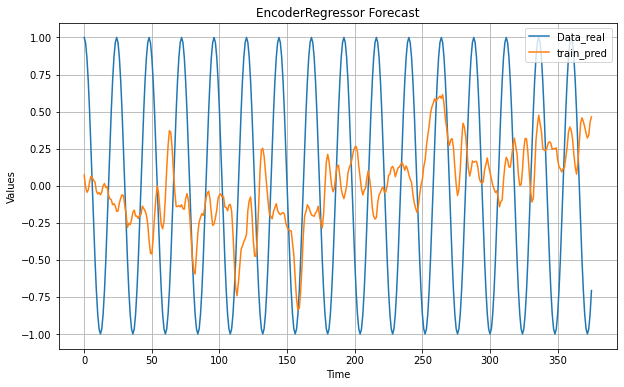

In [401]:
df_evaluate_train.plot(x='Time', figsize=(10,6))
plt.ylabel('Values')
plt.title('EncoderRegressor Forecast')
plt.grid(True)
plt.show()

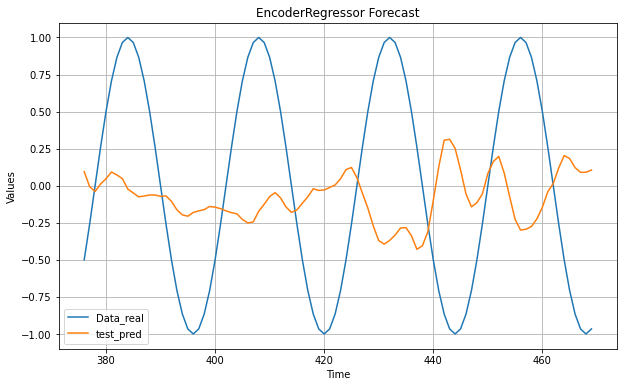

In [402]:
# plt.figure(figsize=(12,8))
df_evaluate_test.plot(x='Time', figsize=(10,6))
plt.ylabel('Values')
plt.title('EncoderRegressor Forecast')
plt.grid(True)
plt.show()

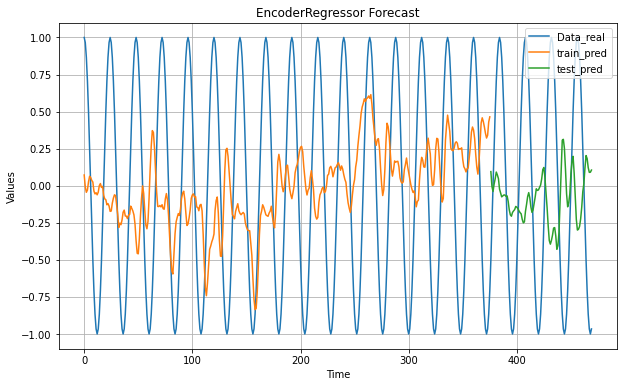

In [403]:
df_evaluate.plot(x='Time', figsize=(10,6))
plt.ylabel('Values')
plt.title('EncoderRegressor Forecast')
plt.grid(True)
plt.show()